https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/cifar10/02_DCGAN_CIFAR10.ipynb

# Dependencies

In [2]:
!pip install tensorflow==1.15

  Using cached https://files.pythonhosted.org/packages/3f/98/5a99af92fb911d7a88a0005ad55005f35b4c1ba8d75fba02df726cd936e6/tensorflow-1.15.0-cp36-cp36m-manylinux2010_x86_64.whl


In [3]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv1D, Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
import pandas as pd

Using TensorFlow backend.


# GAN

In [5]:
class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 128
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img , distance = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)
        
        def norm_loss(y_real, y_pred):
          squared_distance = tf.square(y_real - y_pred)
          squared_distance_reverse = tf.math.sqrt (tf.reduce_mean(squared_distance, axis=-1))
          return 1/squared_distance_reverse

        self.combined = Model(z, [validity, distance])
        self.combined.compile(loss=['binary_crossentropy' , norm_loss], optimizer=optimizer)
    
    
    def build_generator(self):
        model = Sequential()
        #model.add(Dense(2*2*512, input_shape=(self.latent_dim,)))
        #model.add(Reshape((2, 2, 512)))
        #model.add(BatchNormalization())
        #model.add(LeakyReLU(0.2))

        #model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
        #model.add(BatchNormalization())
        #model.add(LeakyReLU(0.2))

        #model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
        #model.add(BatchNormalization())
        #model.add(LeakyReLU(0.2))

       # model.add(Conv2D(64, kernel_size=5, strides=2, padding='same'))
       # model.add(BatchNormalization())
       # model.add(LeakyReLU(0.2))
        #model.add(Conv2D(3, kernel_size=5, strides=2, padding='same', activation='tanh'))

       # model.add(Dense(np.prod(self.img_shape), activation='tanh'))
       # model.add(Reshape(self.img_shape))
        #model.summary()
        #noise = Input(shape=(self.latent_dim,))
        #img = model(noise)
        #return Model(noise, img)


        input_layer = Input(shape=(self.latent_dim,))
        layer = Dense(2*2*512, input_shape=(self.latent_dim,))(input_layer)
        layer = Reshape((2, 2, 512))(layer)
        layer = BatchNormalization()(layer)
        layer = LeakyReLU(0.2)(layer)
        layer = Conv2D(256, kernel_size=5, strides=2, padding='same')(layer)
        layer = BatchNormalization()(layer)
        layer = LeakyReLU(0.2)(layer)

        layer = Conv2D(128, kernel_size=5, strides=2, padding='same')(layer)
        layer = BatchNormalization()(layer)
        layer = LeakyReLU(0.2)(layer)

        layer = Conv2D(64, kernel_size=5, strides=2, padding='same')(layer)
        layer = BatchNormalization()(layer)
        layer = LeakyReLU(0.2)(layer)

        layer = Conv2D(3, kernel_size=5, strides=2, padding='same')(layer)
        layer = Dense(np.prod(self.img_shape), activation='tanh')(layer)
        out1 = Reshape(self.img_shape)(layer)

        # output 2 is dependent to the output 1
        out2 = GlobalAveragePooling2D()(out1)
        out2 =  Dense(1, activation='relu')(out2)

        # output 2 is independent to the output 1
        #out2 =  Dense(1, activation='relu')(layer)

        noise = input_layer
        img = out1
        distance = out2

        model = Model(noise, [img,distance])
        model.summary()
        return model

        
    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(self.img_shape)))
        model.add(LeakyReLU(0.2))

        model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))

        model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))

        model.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))



        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, _), (_, _) = cifar10.load_data()
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            gen_imgs , distance = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            g_loss = self.combined.train_on_batch(noise, [valid,distance])

            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, loss:%f ]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
            if epoch % sample_interval == 0:
               self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs, distance = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("%d.png" % epoch)
        plt.close()

# Train

In [6]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10000, batch_size=64, sample_interval=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_______________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.770565, acc.: 35.94%] [G loss: inf, loss:0.002647 ]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
5001 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:14.390280 ]
5002 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:14.021390 ]
5003 [D loss: 0.000000, acc.: 100.00%] [G loss: inf, loss:14.752172 ]
5004 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:14.597866 ]
5005 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:14.880909 ]
5006 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:14.310903 ]
5007 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:13.990285 ]
5008 [D loss: 0.000000, acc.: 100.00%] [G loss: inf, loss:13.931826 ]
5009 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:14.298921 ]
5010 [D loss: 0.000000, acc.: 100.00%] [G loss: inf, loss:14.366418 ]
5011 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:14.694035 ]
5012 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:14.422699 ]
5013 [D loss: 0.000001, acc.: 100.00%] [G loss: inf, loss:13.790774 ]
5014 [D loss: 0.000001, acc.: 100.00%] 

# Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

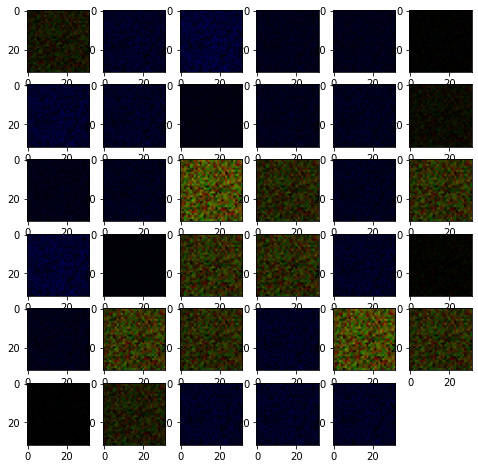

In [7]:
noise = np.random.normal(0, 1, (36,128))
gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


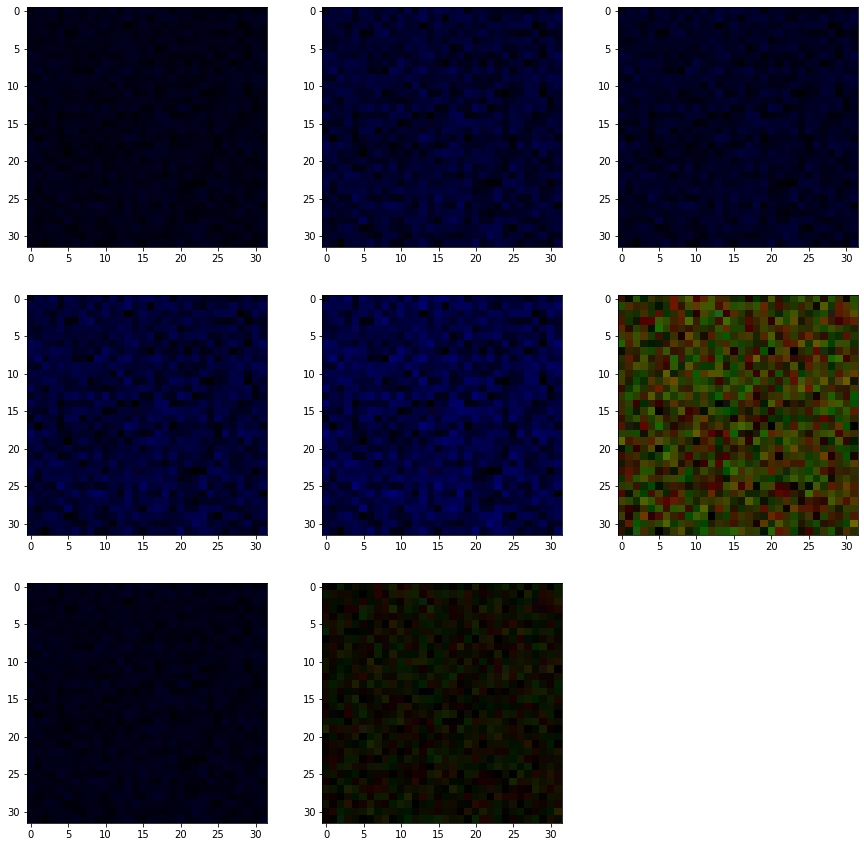

In [8]:
noise = np.random.normal(0, 1, (9,128))
gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


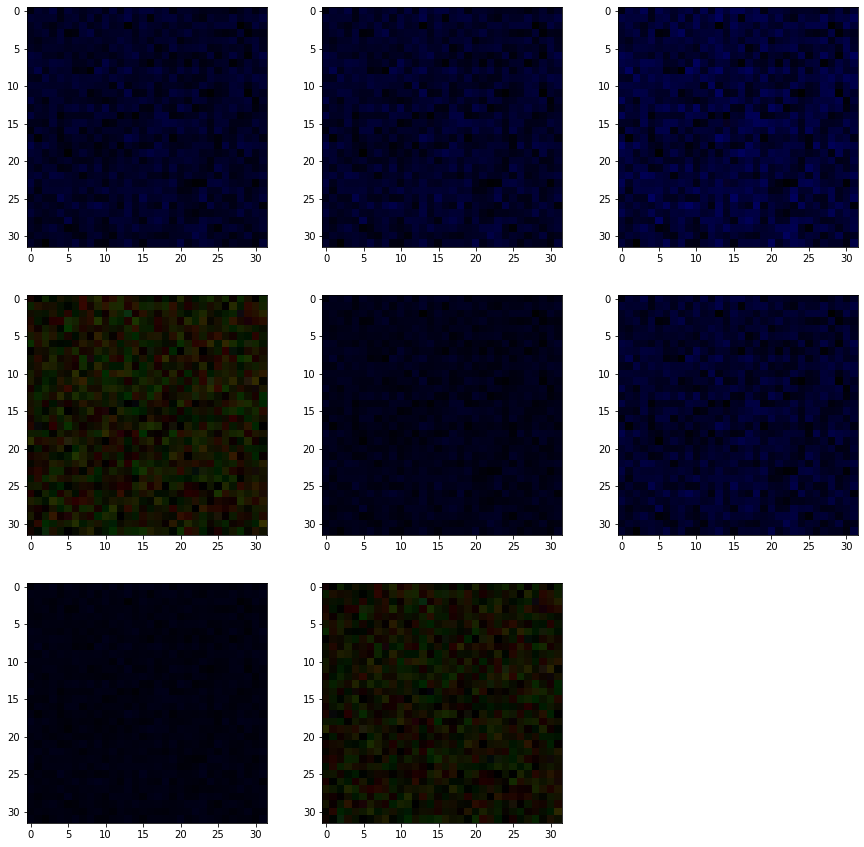

In [15]:
my_file = pd.read_csv('noise_cifar_1_9128.csv')
new_noise = my_file.to_numpy()
noise = new_noise

gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


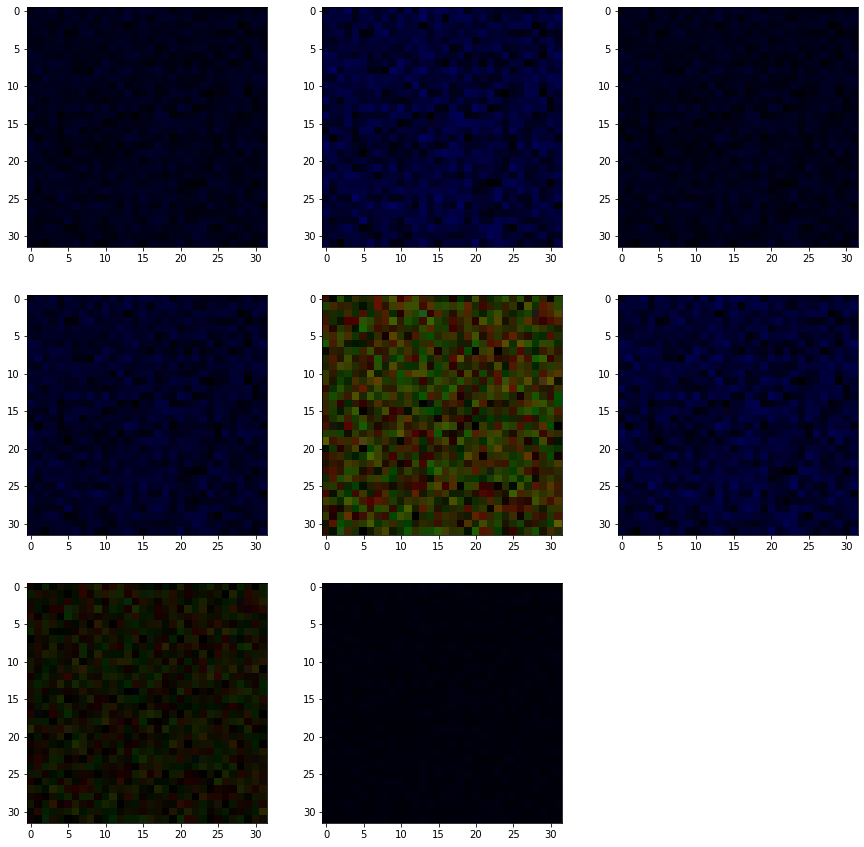

In [16]:
my_file = pd.read_csv('noise_cifar_2_9128.csv')
new_noise = my_file.to_numpy()
noise = new_noise

gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


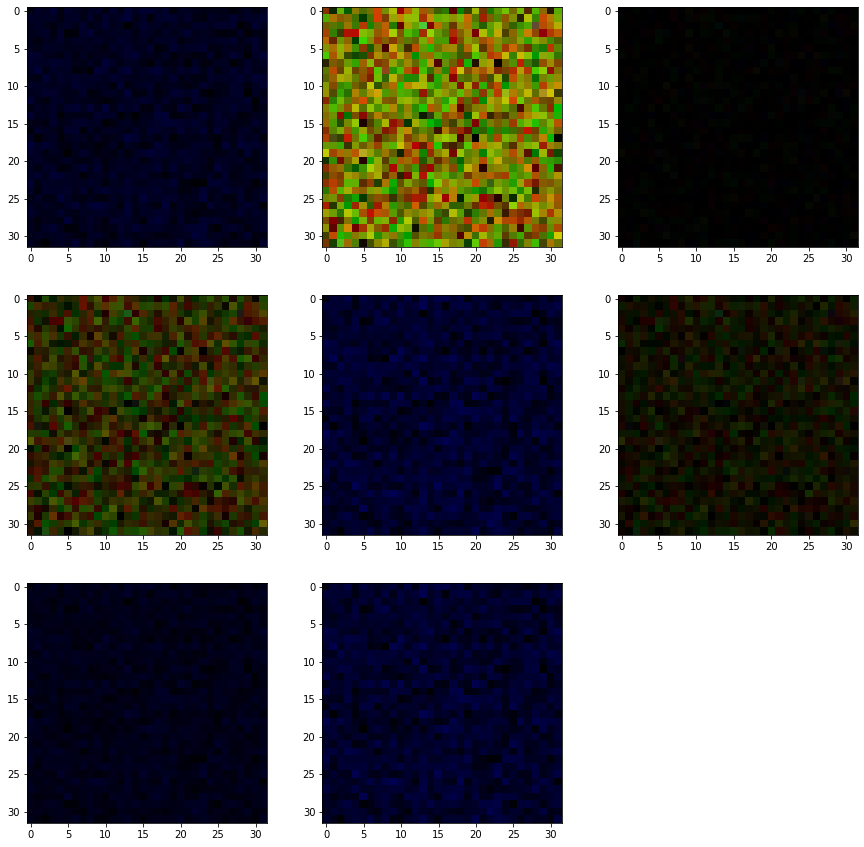

In [17]:
my_file = pd.read_csv('noise_cifar_3_9128.csv')
new_noise = my_file.to_numpy()
noise = new_noise

gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

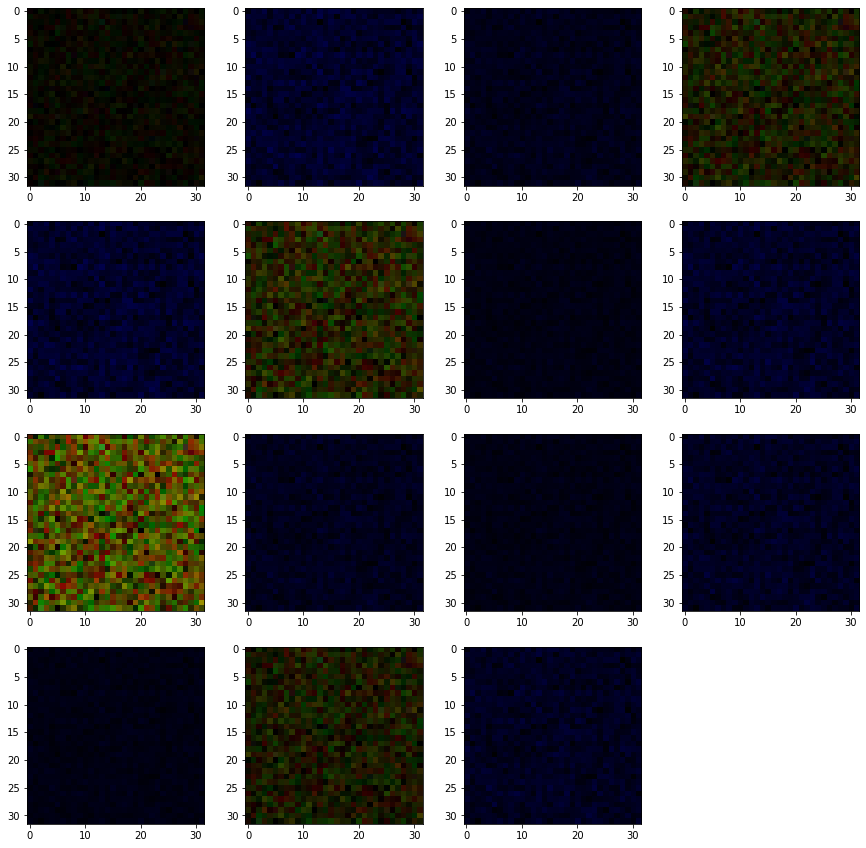

In [18]:
my_file = pd.read_csv('noise_cifar_4_16128.csv')
new_noise = my_file.to_numpy()
noise = new_noise
gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

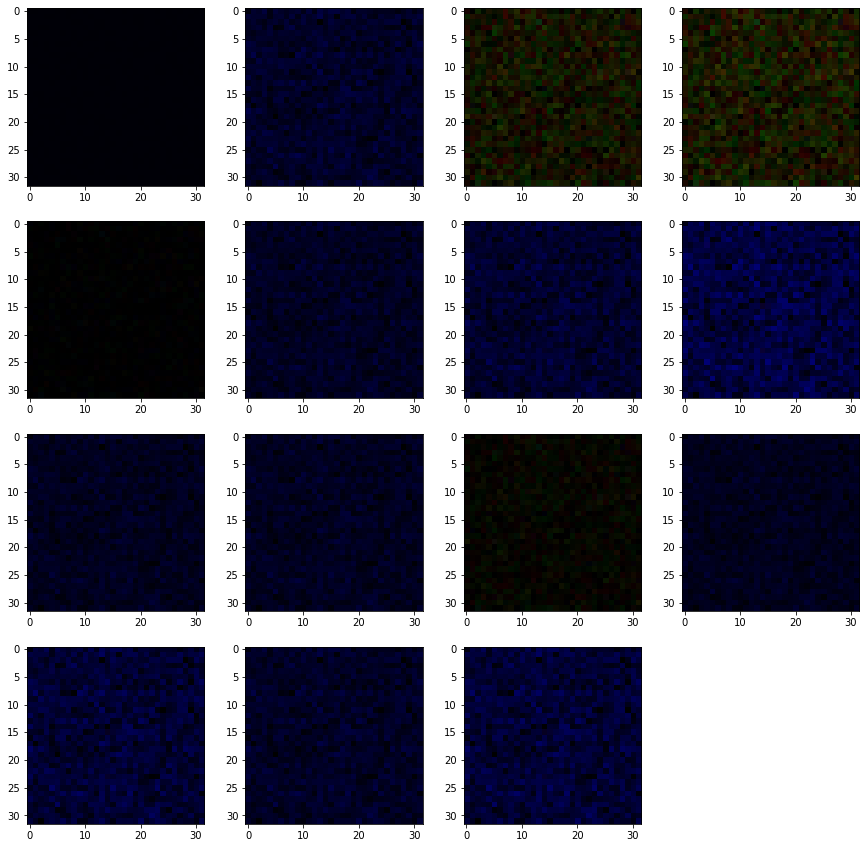

In [19]:
my_file = pd.read_csv('noise_cifar_5_16128.csv')
new_noise = my_file.to_numpy()
noise = new_noise

gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

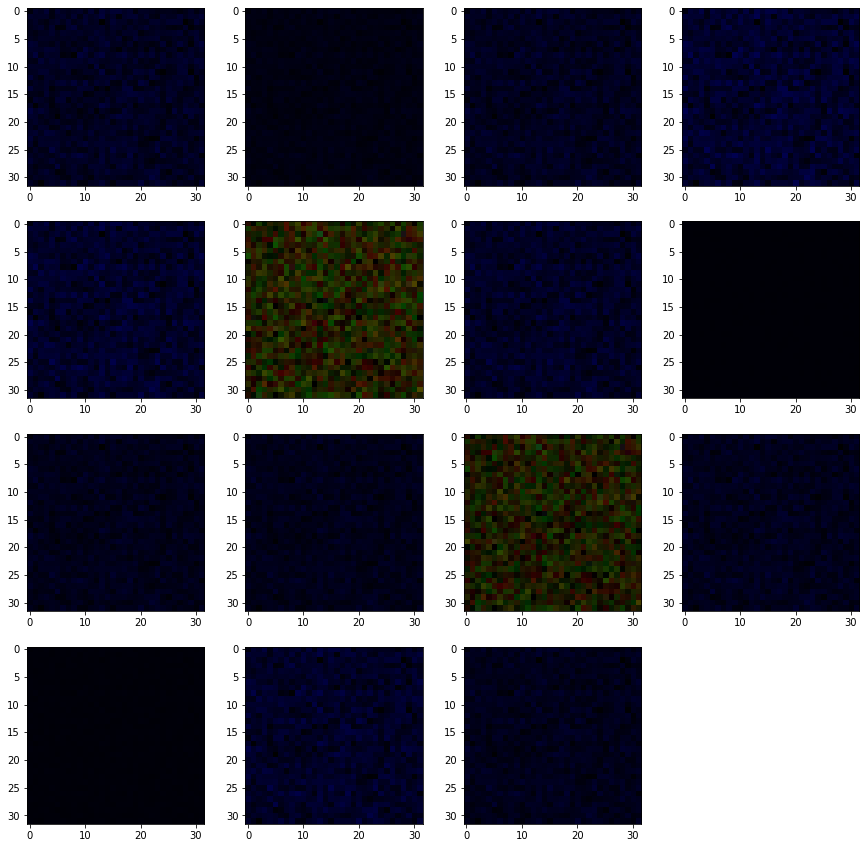

In [20]:
my_file = pd.read_csv('noise_cifar_6_16128.csv')
new_noise = my_file.to_numpy()
noise = new_noise


gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

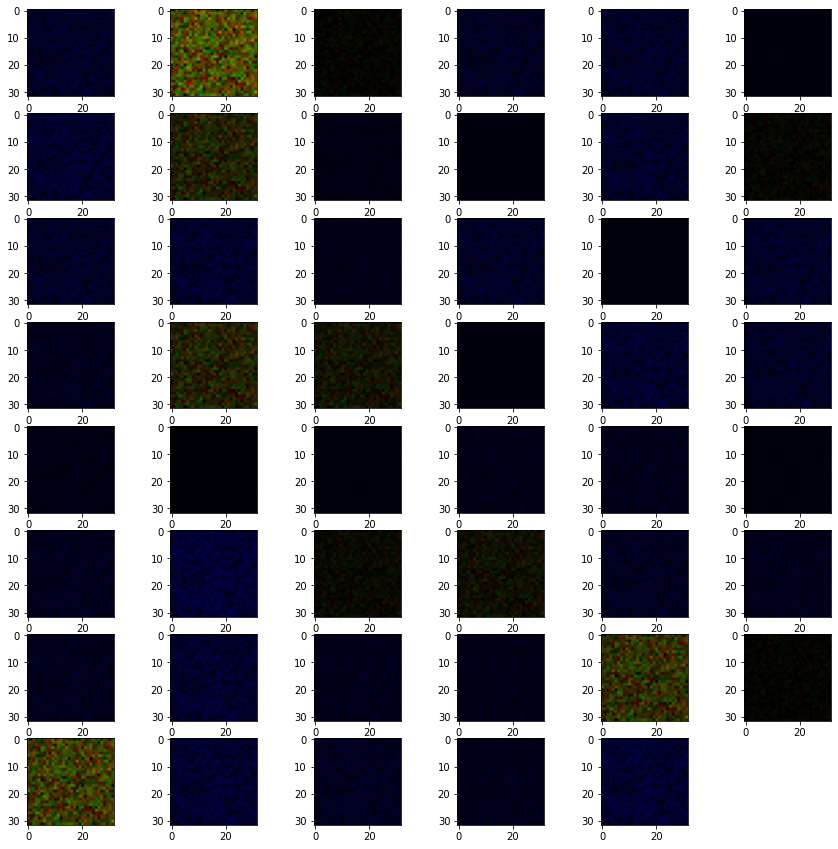

In [21]:
# noise7 - (48,128)
my_file = pd.read_csv('noise_cifar_7_48128.csv')
new_noise = my_file.to_numpy()
noise = new_noise

gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 6
rows = 8

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

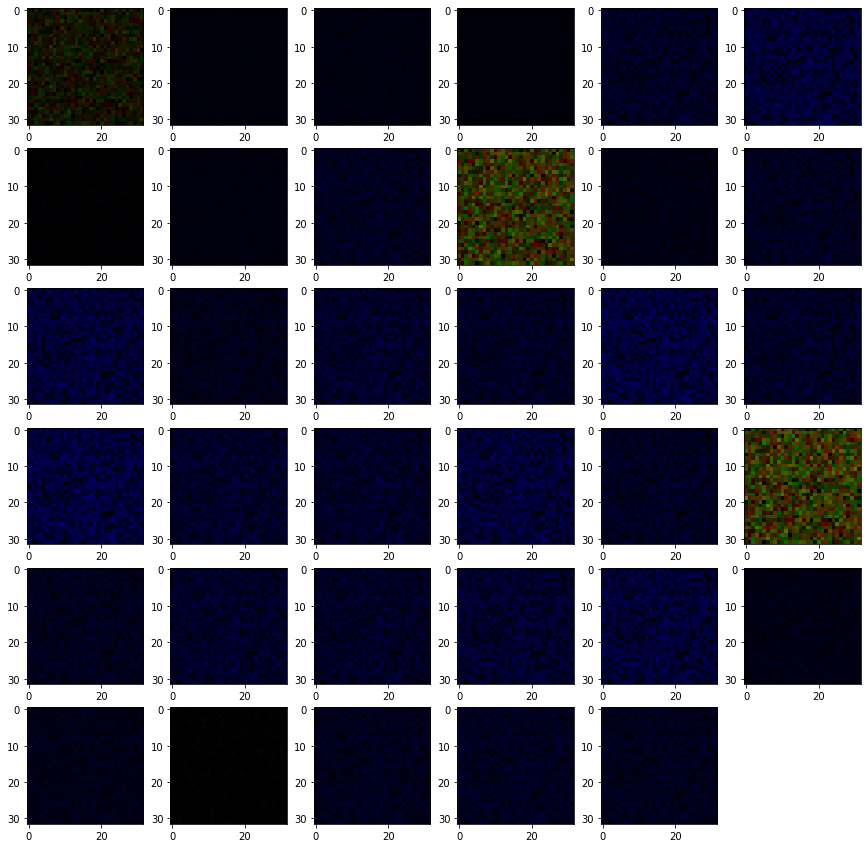

In [22]:
# noise8 - (36,128)
my_file = pd.read_csv('noise_cifar_8_36128.csv')
new_noise = my_file.to_numpy()
noise = new_noise

gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 6
rows = 6

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


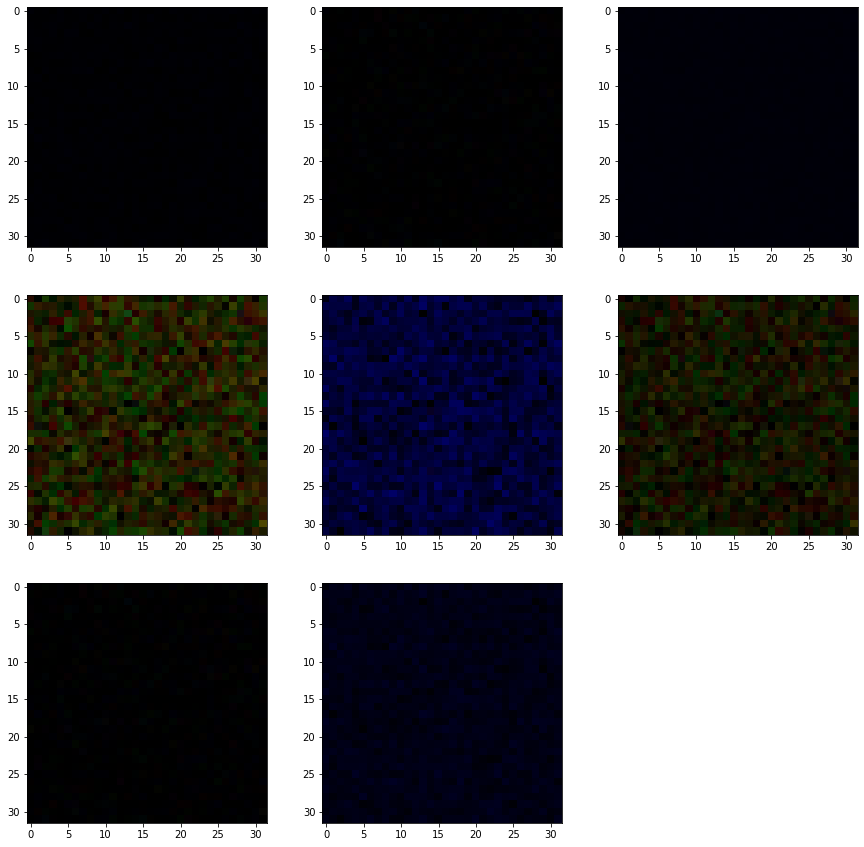

In [23]:
# noise9 - (9,128)
my_file = pd.read_csv('noise_cifar_9_9128.csv')
new_noise = my_file.to_numpy()
noise = new_noise

gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

#4 model pictures has been generated